In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
from kan import KAN
import pandas as pd
import glob
import os
import warnings

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

torch.manual_seed(42)
np.random.seed(42)

device: cuda


In [3]:
model_name = "KAN"               # "MLP" or "KAN"
num = 1                          # dataset number
window_size = 20                 # order of AR model
num_epochs = 300   

# Find matching files
file_pattern = f"datasets/{num}_*.csv"
matching_files = glob.glob(file_pattern)
print(matching_files)

if not matching_files:
    raise FileNotFoundError(f"No dataset files found starting with {num}_")

dataset_path = matching_files[0]
dataset_name = os.path.basename(dataset_path).split("_", 1)[1].replace(".csv", "")
print(f"Reading dataset: {dataset_name} (Path: {dataset_path})")

# Load the dataset
data_csv = pd.read_csv(dataset_path)

# Directly read x and y columns from the CSV file
x = data_csv["x"].values
y = data_csv["y"].values.astype(float)  # Convert to NumPy array

n_points = len(y)

# Create sliding window dataset
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Generate sequence data
X, y = create_sequences(y, window_size)

# Split data into training and testing sets
n_train = int(n_points * 0.8) - window_size
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

# ================== New Section: Train AR Model to Obtain Weights ==================
# Use linear regression as the AR(window_size) model
ar_model = LinearRegression(fit_intercept=False)  # No intercept needed after normalization
ar_model.fit(X_train, y_train)
ar_weights = ar_model.coef_.flatten()

print("AR model weights:", ar_weights)

# Apply AR weights to input data
def apply_ar_weights(data, weights):
    """Apply AR weights to input data"""
    return data * weights

# Apply AR weight transformation
X_train_ar = apply_ar_weights(X_train, ar_weights)
X_test_ar = apply_ar_weights(X_test, ar_weights)

# Convert transformed data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_ar).to(device)
y_train_tensor = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_test_tensor = torch.FloatTensor(X_test_ar).to(device)
# ===============================================================

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the MLP model - Modify input dimension to window_size
class MLP(nn.Module):
    def __init__(self, window_size):
        super(MLP, self).__init__()
        # Input dimension is window_size because each feature is retained after AR transformation
        self.model = nn.Sequential(
            nn.Linear(window_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
if model_name == "MLP":
    model = MLP(window_size).to(device)
elif model_name == "KAN":
    model = KAN(width=[window_size, 50, 1], grid=3, k=3, auto_save=False).to(device)
else:
    raise ValueError("Invalid model name. Choose 'MLP' or 'KAN'.")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses = []

# Use tqdm to create a progress bar
with tqdm(range(num_epochs), desc="Training Progress", unit="epoch") as pbar:
    for epoch in pbar:
        model.train()
        epoch_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        # Dynamically update loss on the progress bar
        pbar.set_postfix(loss=avg_epoch_loss)

# Evaluate the model and make predictions
model.eval()
with torch.no_grad():
    # Training set predictions
    train_predictions = model(X_train_tensor).cpu().numpy()
    
    # Perform step-by-step predictions on the test set
    test_predictions = []
    current_sequence = X_test[0].copy()  # Use the first test sequence as the starting point
    
    for i in range(len(X_test)):
        # Apply AR weight transformation
        current_ar = apply_ar_weights(current_sequence.reshape(1, -1), ar_weights)
        current_tensor = torch.FloatTensor(current_ar).to(device)
        
        next_pred = model(current_tensor).item()
        
        # Denormalize the prediction result
        next_pred_denorm = next_pred
        test_predictions.append(next_pred_denorm)
        
        # Update the sequence (remove the earliest value, add the new predicted value)
        if i < len(X_test) - 1:
            # Get the next real value (used for the next prediction)
            next_real = X_test[i+1][-1]  # Use the last element of the next sequence (i.e., the newest value)
            # Update the sequence: remove the first element, add the next real value
            current_sequence = np.append(current_sequence[1:], next_real)

# Prepare indices for the original time series and prediction results for proper visualization
train_indices = np.arange(window_size, window_size + len(train_predictions))
test_indices = np.arange(window_size + len(train_predictions), n_points)

# Calculate MSE for the test set
test_mse = ((np.array(test_predictions) - y_test) ** 2).mean()
print(f'Test MSE: {test_mse:.4f}')

['datasets/1_a10_ts.csv']
Reading dataset: a10_ts (Path: datasets/1_a10_ts.csv)
AR model weights: [-6.12405395e-02 -1.50115096e-02 -1.87561941e-01 -1.51336747e-01
  1.34310088e-02 -3.19108230e-01 -2.71090902e-01 -6.03182300e-02
  9.69401898e-01  2.23094737e-02  1.37481870e-02 -5.91372847e-04
  7.88916967e-02 -9.06952833e-04  1.83607592e-01  1.44566935e-01
 -1.51814187e-02  2.92485524e-01  2.66833814e-01  1.10729905e-01]


Training Progress: 100%|██████████| 300/300 [21:59<00:00,  4.40s/epoch, loss=0.0081] 


Test MSE: 0.1353


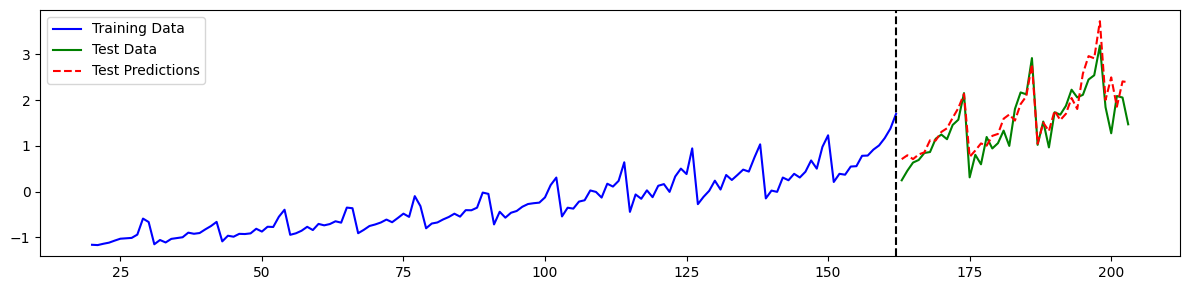

In [4]:
# Draw
plt.figure(figsize=(12, 3))

plt.plot(range(window_size, window_size + len(y_train)), y_train, 'b-', label='Training Data')
plt.plot(range(window_size + len(y_train), window_size + len(y_train) + len(y_test)), y_test, 'g-', label='Test Data')
plt.plot(test_indices, test_predictions, 'r--', label='Test Predictions')
plt.axvline(x=train_indices[-1], color='k', linestyle='--')

plt.legend()
plt.tight_layout()
plt.show()